This tutorial introduces SimSoM: A Simulator of Social Media. 
In this notebook, we provide a minimal example for running a simulation and take a look at the results. 

## Import packages 

In [29]:
try:
    from simsom import SimSom
    from simsom.graphutils import *
    from simsom.utils import *
except ModuleNotFoundError:
    print('Unable to import simsom package. \n' 
    'Change to root directory of this project and run `pip install -e .`')

import json
import numpy as np
import os
from copy import deepcopy

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

There are 2 steps in running a simulation. 
First we create a network (including bot subnetwork) as the input to Simsom, where the simulation happens
- `graph_specs` specifies the parameters for the bot subnetwork ($\beta, \gamma$) and whether to use empirical network data. If "human_network" is None, the human subnetwork is created using a random walk growth model with default values (p=0.5, k_out=3)
- `simulation_specs` specifies the parameters for the simulation, such as $\alpha, \mu, \phi, \theta$

# Create & save the network

In [30]:
DATA_PATH = "data"
net_specs = {
    "targeting_criterion": None,
    "human_network": os.path.join(DATA_PATH, "follower_network.gml"),
    "n_humans": 50,
    "beta": 0.04, # 2 bot
    "gamma": 0.1,# each has 5 followers
    "verbose": True,
}

G = init_net(**net_specs)

network_fpath = os.path.join(DATA_PATH, "infosys_network.gml")
G.write(network_fpath, format="gml")

Reading human network...
Generating bot network...
Merging human and bot networks...
Humans following bots...


# Configure & Run simulations

In [31]:
RESULT_DIR = "results"
reshare_fpath = os.path.join(RESULT_DIR, "reshare.csv")
exposure_fpath = os.path.join(RESULT_DIR, "exposure.csv")
memeinfo_fpath = os.path.join(RESULT_DIR, "meme_info.json.gz")

simulation_specs = {
    "verbose": False,
    "tracktimestep": True,
    "save_memeinfo": True,
    "output_cascades": True,
    "epsilon": 0.0001,
    "mu": 0.5,
    "phi": 1,
    "alpha": 15,
}

no_runs = 2

# Create a list to store results across runs 
quality = []

print("*** Start simulation ***")
for run in range(no_runs):
    print(f"-- Run {run+1}/{no_runs}: \n Create SimSom instance..")
    # Create a SimSom instance
    follower_sys = SimSom(network_fpath, **simulation_specs)

    # Run simulation
    if simulation_specs["output_cascades"] is False:
        results = follower_sys.simulation()
    else:
        results = follower_sys.simulation(
            reshare_fpath=reshare_fpath.replace(".csv", f"_{run}.csv"),
            exposure_fpath=exposure_fpath.replace(".csv", f"_{run}.csv"),
        )
    print(f" - Simulation finished. Quality: {np.round(results['quality'],3)}")

    # Update the quality list
    quality += [results["quality"]]

    # Save verbose results (with simulation specs)
    if simulation_specs["save_memeinfo"] is True:
        specs = deepcopy(simulation_specs)
        specs.update(results)
        fpath = memeinfo_fpath.replace(".json.gz", f"_{run}.json.gz")
        fout = gzip.open(fpath, "w")
        write_json_compressed(fout, specs)
        
# Save short results (with simulation specs)
short_results = deepcopy(simulation_specs)
short_results.update({"quality": quality})
json.dump(short_results, open(os.path.join(RESULT_DIR, "results.json"), "w"))

print(f"*** Average quality across {no_runs} runs: {np.round(np.mean(quality),3)} ***")

*** Start simulation ***
-- Run 1/2: 
 Create SimSom instance..
 - Simulation finished. Quality: 0.269
-- Run 2/2: 
 Create SimSom instance..
 - Simulation finished. Quality: 0.282
*** Average quality across 2 runs: 0.275 ***


# Explore the results 

The short result, containing only simulation specs and quality across runs is stored in __results/results.json__. 
SimSom additionally keeps track of other information in a dictionary, stored in __'results/meme_info_*.json.gz'__, such as:
- message popularity ('all_memes' key)
- human news feed ('all_feeds' key)
- quality across timesteps ('quality_timestep' key)
It also outputs reshare and exposure data in an edgelist format that can be used to reconstruct the cascade (__results/exposure_*.csv__ and __reshare_*.csv__, respectively) 
Let's first check what's available

In [32]:
verbose = read_json_compressed('results/meme_info_0.json.gz')
verbose.keys()

dict_keys(['verbose', 'tracktimestep', 'save_memeinfo', 'output_cascades', 'epsilon', 'mu', 'phi', 'alpha', 'quality', 'diversity', 'discriminative_pow', 'quality_timestep', 'all_memes', 'all_feeds'])

Let's take a look at message popularity, where each row is information about a message.

In [33]:
import pandas as pd
messages = pd.DataFrame.from_records(verbose['all_memes'])
messages.head()

,id,is_by_bot,phi,quality,fitness,agent_id,human_shares,bot_shares,spread_via_agents,seen_by_agents,infeed_of_agents,qual_th,share_th
0,1,0.0,1,0.119049,0.119049,43.0,1,0,[43.0],[],[],585,497
1,2,0.0,1,0.305471,0.305471,44.0,1,0,[44.0],[],[],1232,1045
2,3,0.0,1,0.574919,0.574919,19.0,1,0,[19.0],"[9.0, 9.0, 9.0, 9.0]","[9.0, 9.0, 9.0, 9.0]",1881,1588
3,4,0.0,1,0.058250,0.058250,33.0,1,0,[33.0],[],[],301,237
4,5,0.0,1,0.273935,0.273935,10.0,7,0,"[10.0, 15.0, 12.0, 16.0, 16.0, 12.0, 13.0]","[15.0, 12.0, 16.0, 15.0, 16.0, 17.0, 19.0, 16....","[15.0, 12.0, 16.0, 15.0, 16.0, 17.0, 19.0, 16....",1128,2161


We can also plot the quality of the network over time until convergence.

Text(0.5, 1.0, 'Quality vs timestep')

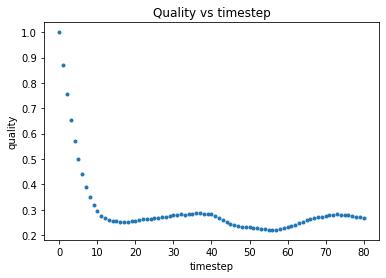

In [34]:
import matplotlib.pyplot as plt

timesteps= len(verbose['quality_timestep'])
plt.scatter(range(timesteps), verbose['quality_timestep'], s=9)
plt.xlabel('timestep')
plt.ylabel('quality')
plt.title('Quality vs timestep')

This concludes our introductory tutorial to SimSom. Read our paper to learn more about possible analysis and our findings on an empirical network using this Simulator, and get in touch with us at our GitHub repo if you have any questions/issues!